In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('data/diabetes_downsampled.csv')

In [ ]:
df.shape

In [ ]:
df.head()

### Data Preprocessing

In [ ]:
#Remove diabetes instances as we are only interested in non-diabetes and pre-diabetes
#0 is for no diabetes , 1 is for prediabetes, and 2 is for diabetes

In [ ]:
df1 = df[(df.Diabetes_012==0) | (df.Diabetes_012==1)]

In [ ]:
df1.shape

In [ ]:
#Number of non-diabetes instances
df1[(df1.Diabetes_012==0)].shape

In [ ]:
df1[(df1.Diabetes_012==1)].shape

In [ ]:
df1[(df1.Diabetes_012==0)][df1.columns[0]]

#### Data highly unbalanced with only 10.4% of the data as pre-diabetes

## Split Dataset before Data sampling

In [ ]:
#Using test_size of 30% of undersampled to split both majority and minority classes to provide a balanced test set
test_size1 = 0.3* df1[(df1.Diabetes_012==1)].shape[0]/df1[(df1.Diabetes_012==0)].shape[0]
test_size2 = 0.3

In [ ]:
#split training set
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df1[(df1.Diabetes_012==0)][df1.columns[1:]], df1[(df1.Diabetes_012==0)][df1.columns[0]],
                                                            test_size=test_size1)

In [ ]:
X_train_1.shape

In [ ]:
X_test_1.shape

In [ ]:
#split test set
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df1[(df1.Diabetes_012==1)][df1.columns[1:]], df1[(df1.Diabetes_012==1)][df1.columns[0]],
                                                            test_size=test_size2)

In [ ]:
X_train_2.shape

In [ ]:
X_test_2.shape

### merge training splits and test splits

In [ ]:
X_train = pd.concat([X_train_1, X_train_2],ignore_index=True)

In [ ]:
X_train.shape

In [ ]:
y_train = pd.concat([y_train_1, y_train_2],ignore_index=True)

In [ ]:
y_train.value_counts()

In [ ]:
X_test = pd.concat([X_test_1, X_test_2],ignore_index=True)

In [ ]:
X_test.shape

In [ ]:
y_test = pd.concat([y_test_1, y_test_2],ignore_index=True)

In [ ]:
y_test.value_counts()

#### Undersample majority class

In [ ]:
df_train=pd.concat([X_train , y_train], axis = 1).reset_index(drop=True)

In [ ]:
df_majority = df_train[df_train.Diabetes_012==0]
df_minority = df_train[df_train.Diabetes_012==1]

In [ ]:
# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                      replace=False,    # sample without replacement
                                      n_samples=int(len(df_minority)*1.2),     # to match minority class
                                      random_state=123) # reproducible results

In [ ]:
df_majority_downsampled.shape

In [ ]:
df_train_downsampled = pd.concat([df_majority_downsampled, df_minority],ignore_index=True)

In [ ]:
df_train_downsampled

## Data Transformation

In [ ]:
df_train_downsampled.columns

In [ ]:
numerical_columns = ['BMI','GenHlth', 'MentHlth', 'PhysHlth','Age', 'Education', 'Income']

In [ ]:
categorical_columns = ['HighBP', 'HighChol', 'CholCheck','Smoker', 'Stroke',
        'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
        'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost','DiffWalk', 'Sex',
        'Diabetes_012']

In [ ]:
# standardise features
# Create the Scaler object
def standardise(df,num_cols):
    scaler = preprocessing.StandardScaler()
    # Fit your data on the scaler object
    scaled_df = scaler.fit_transform(df[num_cols])
    scaled_df = pd.DataFrame(scaled_df, columns=num_cols)
    
    return scaler, scaled_df

In [ ]:
std_scaler, scaled_df_train = standardise(df_train_downsampled,numerical_columns)
df_train_down_stand = pd.concat([scaled_df_train, df_train_downsampled[categorical_columns]], axis = 1)

In [ ]:
df_train_down_stand.head()

#### Transform test dataset using the standardisation object;std_scaler

In [ ]:
scaled_df_test = std_scaler.transform(X_test[numerical_columns])

In [ ]:
scaled_df_test = pd.DataFrame(scaled_df_test, columns=numerical_columns)

In [ ]:
X_test = pd.concat([scaled_df_test, X_test[categorical_columns[:-1]]], axis = 1)

In [ ]:
X_test.head()

## Train Machine Learning Models

In [ ]:
X_train = df_train_down_stand[df_train_down_stand.columns[:-1]]

In [ ]:
y_train = df_train_down_stand[df_train_down_stand.columns[-1]]

#### Random Forest

In [ ]:
# Number of trees in random forest
n_estimators = [50,100,200]

#information gain algorithm
criterion=['gini','entropy']

# Number of features to consider at every split
max_features = [1,0.5]
max_features.append('auto')

# Maximum number of levels in tree
max_depth = [10,50,100]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 10, 20]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 4, 8]

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'criterion': criterion,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

In [ ]:
RF = RandomForestClassifier()

### Grid Search

In [ ]:
# Instantiate the grid search model
rand_search = RandomizedSearchCV(estimator = RF, param_distributions = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
rand_search.fit(X_train, y_train)

In [ ]:
print(rand_search.best_params_)

In [ ]:
best_ML = rand_search.best_estimator_

## Evaluate our trained model

In [ ]:
# Training and Test Accuracies
best_ML.fit(X_train, y_train)
y_val_train=best_ML.predict(X_train)
y_val_test=best_ML.predict(X_test)

In [ ]:
#Training Classification Report
print(classification_report(y_train,y_val_train))
print(confusion_matrix(y_train,y_val_train))
print(accuracy_score(y_train,y_val_train))

In [ ]:
#Test Classification Report
print(classification_report(y_test,y_val_test))
print(confusion_matrix(y_test,y_val_test))
print(accuracy_score(y_test,y_val_test))

### Explain the importance of features in the trained model predictions

In [ ]:
importances = best_ML.feature_importances_

In [ ]:
feat_importances = pd.Series(importances, index=X_train.columns)

In [ ]:
feat_importances = feat_importances.sort_values(ascending=False)

In [ ]:
feat_importances.plot.bar()
plt.title("Feature importances of predicting prediabetes")
plt.ylabel("Mean decrease in impurity")
plt.show()


In [88]:
print(rand_search.best_params_)

{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 10, 'criterion': 'entropy'}


In [89]:
best_ML = rand_search.best_estimator_

## Evaluate our trained model

In [91]:
# Training and Test Accuracies
best_ML.fit(X_train, y_train)
y_val_train=best_ML.predict(X_train)
y_val_test=best_ML.predict(X_test)

In [93]:
#Training Classification Report
print(classification_report(y_train,y_val_train))
print(confusion_matrix(y_train,y_val_train))
print(accuracy_score(y_train,y_val_train))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81      3889
           1       0.76      0.81      0.79      3241

    accuracy                           0.80      7130
   macro avg       0.80      0.80      0.80      7130
weighted avg       0.80      0.80      0.80      7130

[[3066  823]
 [ 605 2636]]
0.7997194950911641


In [94]:
#Test Classification Report
print(classification_report(y_test,y_val_test))
print(confusion_matrix(y_test,y_val_test))
print(accuracy_score(y_test,y_val_test))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70      1390
           1       0.70      0.70      0.70      1390

    accuracy                           0.70      2780
   macro avg       0.70      0.70      0.70      2780
weighted avg       0.70      0.70      0.70      2780

[[978 412]
 [415 975]]
0.7025179856115108


### Explain the importance of features in the trained model predictions

In [97]:
importances = best_ML.feature_importances_

In [99]:
feat_importances = pd.Series(importances, index=X_train.columns)

In [113]:
feat_importances = feat_importances.sort_values(ascending=False)

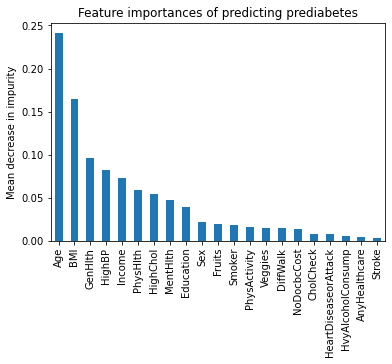

In [114]:
feat_importances.plot.bar()
plt.title("Feature importances of predicting prediabetes")
plt.ylabel("Mean decrease in impurity")
plt.show()
